![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Importación librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [6]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [7]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('pred/test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033


### Exploración de datos

In [8]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [9]:
dataTraining.describe(include='object')

,State,Make,Model
count,400000,400000,400000
unique,51,38,525
top,TX,Ford,Silverado
freq,45918,62899,18085


In [10]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


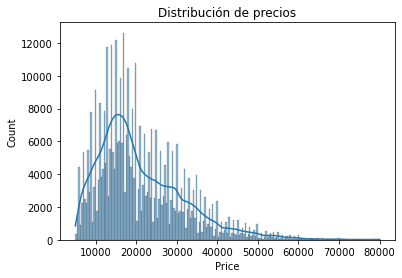

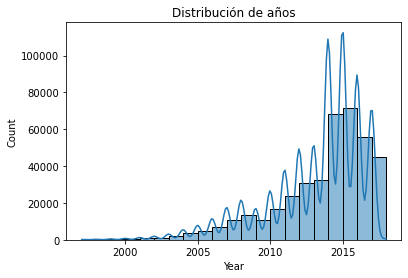

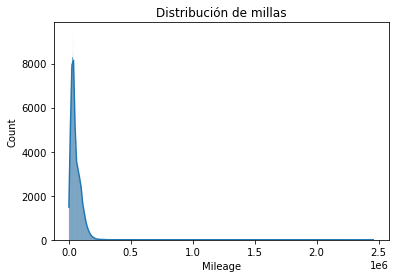

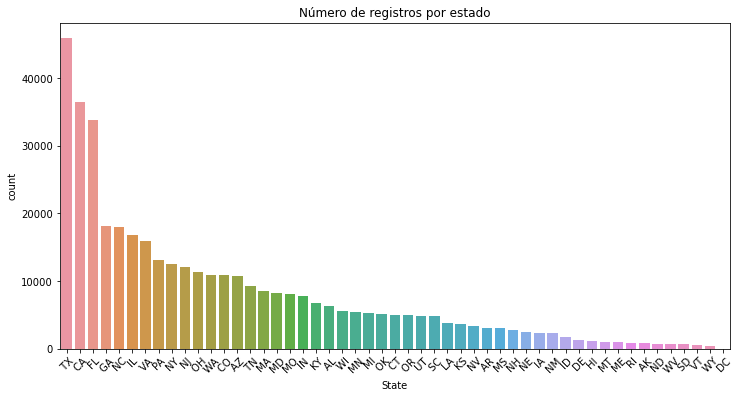

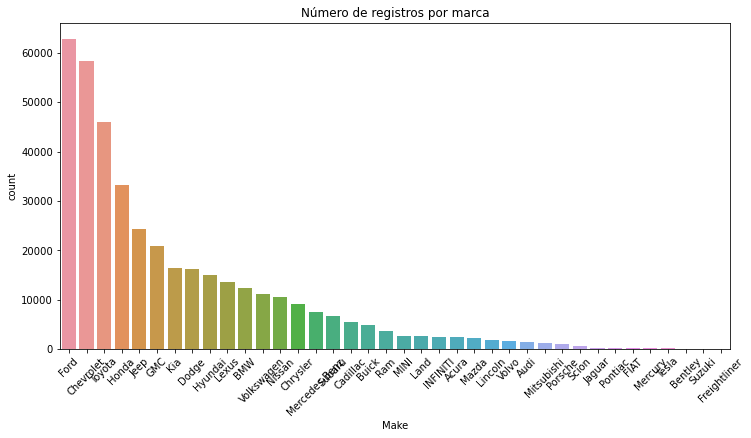

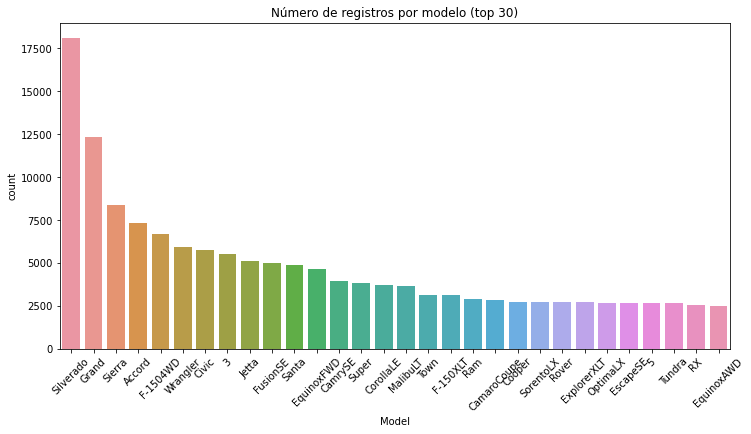

In [11]:
# Gráfica de distribución de precios
sns.histplot(dataTraining['Price'], kde=True)
plt.title('Distribución de precios')
plt.show()

# Gráfica de distribución de años
sns.histplot(dataTraining['Year'], kde=True, bins=range(dataTraining['Year'].min(), dataTraining['Year'].max() + 1))
plt.title('Distribución de años')
plt.show()

# Gráfica de distribución de millas
sns.histplot(dataTraining['Mileage'], kde=True)
plt.title('Distribución de millas')
plt.show()

# Gráfico de barras para la columna 'State'
plt.figure(figsize=(12, 6))
sns.countplot(data=dataTraining, x='State', order=dataTraining['State'].value_counts().index)
plt.title('Número de registros por estado')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para la columna 'Make'
plt.figure(figsize=(12, 6))
sns.countplot(data=dataTraining, x='Make', order=dataTraining['Make'].value_counts().index)
plt.title('Número de registros por marca')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para la columna 'Model'
plt.figure(figsize=(12, 6))
sns.countplot(data=dataTraining, x='Model', order=dataTraining['Model'].value_counts().iloc[:30].index)
plt.title('Número de registros por modelo (top 30)')
plt.xticks(rotation=45)
plt.show()

## 1. Preprocesamiento de datos (10 puntos)

* Los datos de entrenamiento se dividen en datos de entrenamiento y validación. Si decidieron preprocesar los datos (estandarizar, normalizar, imputar valores, etc), estos son correctamente preprocesados al ajustar sobre los datos de entrenamiento (.fit_transform()) y al transformar los datos del set de validación (.transform()). (10 puntos)

In [47]:
df = dataTraining.copy()
dfT = dataTesting.copy()

In [48]:
# Combinar los conjuntos de datos de entrenamiento y prueba
df_combined = pd.concat([df, dfT])

# Realizar la codificación de frecuencia en las columnas categóricas
for col in ['State', 'Make', 'Model']:
    freq_encoding = df_combined[col].value_counts() / len(df_combined)
    df[col] = df[col].map(freq_encoding)
    dfT[col] = dfT[col].map(freq_encoding)

In [49]:
# Separación en datos de entrenamiento y valización 
X = df.drop("Price", axis=1)
y = df["Price"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Crear un pipeline de preprocesamiento para estandarizar los datos numéricos
numeric_features = ["Year", "Mileage"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Aplicar el preprocesamiento en los conjuntos de entrenamiento y validación
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

In [68]:
dfT_processed = preprocessor.transform(dfT)

## 2. Calibración del modelo (15 puntos)

* Se calibran los parámetros que se consideren pertinentes del modelo de clasificación seleccionado. (5 puntos)

* Se justifica el método seleccionado de calibración. (5 puntos)

* Se analizan los valores calibrados de cada parámetro y se explica cómo afectan el modelo. (5 puntos)

### 2.1 Random forest

In [62]:
def save_pred(model, file_name, dfT_i):
    y_pred = pd.DataFrame(model.predict(dfT_i), index=dataTesting.index, columns=['Price'])
    y_pred.to_csv(f'pred/{ file_name }.csv', index_label='ID')

In [63]:
def adjusted_r2_score(y_true, y_pred):
    n_samples = X_val_scaled.shape[0]
    n_features = X_val_scaled.shape[1]
    r2 = r2_score(y_true, y_pred)
    r2_adj  = 1 - ((1 - r2) * (n_samples - 1)) / (n_samples - n_features - 1)
    return (r2, r2_adj )

def evaluate_model(model, X_val):
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2, r2_adj = adjusted_r2_score(y_val, y_pred)

    measures_dic = {
        'MSE': mse,
        'R2': r2,
        'R2 ADJ': r2_adj
    }

    display(measures_dic)


In [60]:
# Crear y entrenar el modelo de regresión XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model.fit(X_train_processed, y_train,
          early_stopping_rounds=10,
          eval_set=[(X_val_processed, y_val)],
          verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [64]:
evaluate_model(model, X_val_processed)

{'MSE': 80439985.82106397,
 'R2': 0.30472562892532273,
 'R2 ADJ': 0.30394255451071717}

In [69]:
save_pred(model, 'xgb', dfT_processed)

In [ ]:
# rf_model = RandomForestRegressor(random_state=42)

# #Definir los parámetros que deseas calibrar y los valores que deseas explorar
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 10, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Crear el objeto GridSearchCV
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# # Ajustar el GridSearchCV a los datos de entrenamiento
# grid_search.fit(X_train_scaled, y_train)
# print("Mejores parámetros: ", grid_search.best_params_)
# best_rf_model = grid_search.best_estimator_
# evaluate_model(best_rf_model)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


## 3. Disponibilización del modelo (30 puntos)

* Se disponibiliza el modelo en una API alojada en un servicio en la nube. (20 puntos)

* Se hacen las predicciones sobre el valor del automóvil en al menos dos observaciones del set de validación. (10 puntos)

## 4. Conclusiones (10 puntos)

* Se presentan conclusiones claras y concisas sobre el desarrollo y los resultados del proyecto. (10 puntos)